## Europeana - Exploration of a collection

This notebook explains how you can use Europeana's SPARQL endpoint to explore the contents of the collection of a specific cultural heritage institution. 

The cell below firstly defined a number of functions that can be used to run SPAQRL queries and to analyse the results in Python. 

In [1]:
from SPARQLWrapper import SPARQLWrapper, JSON
from IPython.core.display import display, HTML
import pandas as pd
import re
from IPython.core.display import display, HTML

endpoint = 'http://sparql.europeana.eu/'
sparql = SPARQLWrapper(endpoint)

def run_query(sparql_query):
    sparql.setQuery(sparql_query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()
    df = pd.json_normalize(data['results']['bindings'])  
    return df

def print_results(df):
    for i,row in df.iterrows():
        for column in df.columns:
            if re.search('value$' , column):
                print( f'{column} => {row[column]}' )
        print('-------')

The query below firstly generates a list of all the institutions that contribute to Europeana in the Netherlands. 

In [2]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>

SELECT ?glam_inst , COUNT(?glam_inst)
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .

?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider ?glam_inst .
?eur_aggr edm:country 'netherlands' .
}
GROUP BY ?glam_inst

"""

df = run_query(query)



As you can see, the query groups the results by institution and counts the number of items for each institution. Using this query, we can establish that there are 159 Dutch institutions which added objects to Europeana. 

The code below lists of all the institutions which have contributed more than 10,000 objects. 

In [3]:
print( f'{df.shape[0]} Dutch institutions contribute to Europeana.' )

print( f'\nThe following institutions have contributed more that 10000 objects:' )

df = df.sort_values(by=['glam_inst.value']  )

count = 0 
for i,row in df.iterrows():
    if int(row['callret-1.value']) > 10000:
        count += 1
        print( f"{count}. {row['glam_inst.value']}: {row['callret-1.value']}" )

159 Dutch institutions contribute to Europeana.

The following institutions have contributed more that 10000 objects:
1. Beeldbank Wageningen: 12792
2. Brabants Historisch Informatie Centrum: 163454
3. CODA Apeldoorn: 30699
4. CODA Museum: 10580
5. Circus Museum: 16580
6. Deventer Musea: 37394
7. Digitale bibliotheek voor de Nederlandse letteren, DBNL, Nederland: 17043
8. Erfgoed Rijssen-Holten: 17221
9. Euregionaal Historisch Centrum Sittard-Geleen (ehc.sittard-geleen.eu): 53054
10. EuroPhoto ANP provider: 155448
11. Gemeente Schouwen-Duiveland: 37755
12. Gemeentearchief Ede-Barneveld: 41483
13. Gemeentearchief Roosendaal: 63465
14. Gemeentearchief Schiedam: 38651
15. Gemeentearchief Tholen: 27160
16. Gemeentearchief Weert: 75024
17. Gemeentearchief Zaanstad: 85843
18. Gemeentemuseum Den Haag: 19558
19. Gooi en Vecht Historisch: 56505
20. Haags Gemeentearchief: 210084
21. Het Nationaal Glasmuseum: 72631
22. Historisch Centrum Leeuwarden: 44268
23. Historisch Centrum Limburg (rhcl.nl):

# Examine collection of the Rijksmuseum

In the remainder of this notebook, we shall focus on the collection of the Rijksmuseum in Amsterdam (item 51 in this list). Using COUNT() in the query below, we can verify the information about the number of items added by this institution.

In [4]:


query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>

SELECT COUNT( DISTINCT ?object )
WHERE {


?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:provider ?glam .

?local_aggr edm:dataProvider 'Rijksmuseum' .
}
"""

df = run_query(query)
print( f"There are {df['callret-0.value'].iloc[0]} items in this collection." )


There are 350349 items in this collection.


Which kinds of objects can we find in this collection? We can explore the contents of this collection by examing the values supplied for `edm:type`.

In [5]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>

SELECT ?type , COUNT(?type)
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .
?object dc:type ?type .

}
GROUP BY ?type
"""


types_df = run_query(query)

The object types have been described using the Rijksmuseum thesaurus and using the [Getty Vocabularies](http://vocab.getty.edu/). The cell below creates a list of the most frequently assigned categories. 

In [6]:
getty_types = []

for i, row in types_df.iterrows():
    if re.search( r'getty' , row['type.value']):
        getty_types.append(row['type.value'])

    if int(row['callret-1.value']) > 5000:
        print( f"{row['type.value']} => {row['callret-1.value']} objects." )

urn:rijksmuseum:thesaurus:RM0001.THESAU.66314 => 69512 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.27459 => 15044 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.98251 => 7652 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.236 => 14530 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.1433 => 9919 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.9716 => 21708 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.20691 => 10267 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.679 => 24390 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.2279 => 5076 objects.
http://vocab.getty.edu/aat/300053271 => 18941 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.27272 => 94026 objects.
http://vocab.getty.edu/aat/300041273 => 184213 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.8064 => 13882 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.2140 => 8497 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.12638 => 5346 objects.
urn:rijksmuseum:thesaurus:RM0001.THESAU.1356 => 11981 objects.
urn:rijk

For each type, we can also request a human-understandable label, using the `skos:prefLabel` predicate. 

In [7]:
endpoint = 'http://sparql.europeana.eu/'
sparql = SPARQLWrapper(endpoint)

query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?label , COUNT(?label)
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .
?object dc:type ?type .
?type skos:prefLabel ?label . 
FILTER( lang(?label) = 'en' )

}
GROUP BY ?label
"""


types_df = run_query(query)
types_df['callret-1.value'] = types_df['callret-1.value'].astype(int)
types_df = types_df.sort_values(by=['callret-1.value'] , ascending = False )

for i,row in types_df.iterrows():
    print( f"{row['label.value']} => {row['callret-1.value']}" )


prints (visual works) => 189523
lithography => 19190
stereoscopic photographs => 8009
gelatin silver process => 5195
drypoint (printing process) => 3680
easel paintings (paintings by form) => 3445
collotype (process) => 2569
weaving => 1887
Woodburytype (process) => 1626
plates (general, dishes) => 1554
cabinet photographs => 1430
salted paper prints => 921
cyanotypes (photographic prints) => 491
photomechanical processes => 436
dishes (vessels) => 383
ribbon (material) => 379
braid (trimming) => 309
brocading => 277
carbon process => 259
ferrotyping => 256
daguerreotype (process) => 253
ambrotype (wet collodion process) => 237
playing cards => 208
tapestry (process) => 202
gameboards (board game elements) => 200
sewing (needleworking techinique) => 197
poems => 190
photolithography => 184
textile materials => 183
chandeliers (hanging lights) => 118
scrapbooks => 114
platinum process => 103
tokens (exchange media) => 102
slides (photographs) => 102
lantern slides => 99
models (represen

In this overview, we can see that the type "easel paintings (paintings by form)", from the Getty Vocabularies has been assigned very frequently, namely, more than 3440 times. 

Using the results of the following query, we can display a number of examples of works in this category. 

In [8]:

query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?title ?label ?url ?landing
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:title ?title .
?object dc:type ?type .
?type skos:prefLabel ?label .
FILTER( regex(lang(?title),'en') )
FILTER( regex(?label,'easel paintings') )
?local_aggr edm:isShownBy ?url .
?local_aggr edm:isShownAt ?landing .
}
LIMIT 30
"""

df =run_query(query) 
print( f'{df.shape[0]} results.' )

df.columns
for i,row in df.iterrows():
    print( row['title.value'] )
    print( row['landing.value'] )
    img = row['url.value']
    display(HTML(f'<a target="_new" href="{img}"><img src="{img}" style="width: 200px;"/></a><br/><br/>'))



30 results.
Rough Sea
http://hdl.handle.net/10934/RM0001.COLLECT.5892


Country Inn
http://hdl.handle.net/10934/RM0001.COLLECT.8362


Gelder Landscape
http://hdl.handle.net/10934/RM0001.COLLECT.5370


Farmhouse near Helvoirt
http://hdl.handle.net/10934/RM0001.COLLECT.5913


The Navy's Frigate 'Rotterdam' on the Maas off Rotterdam
http://hdl.handle.net/10934/RM0001.COLLECT.5943


City Wall with Gunpowder Magazine
http://hdl.handle.net/10934/RM0001.COLLECT.5974


Nicolaes van der Borght, Merchant of Antwerp
http://hdl.handle.net/10934/RM0001.COLLECT.6670


The Choir of the O.L.-Vrouwekerk in Breda with the Tomb of Engelbert II of Nassau
http://hdl.handle.net/10934/RM0001.COLLECT.6178


Flowers in a Terra Cotta Vase
http://hdl.handle.net/10934/RM0001.COLLECT.6220


The Poultryman
http://hdl.handle.net/10934/RM0001.COLLECT.7095


After Milking Time
http://hdl.handle.net/10934/RM0001.COLLECT.8102


The Torensluis and the Jan Roodenpoortstoren in Amsterdam
http://hdl.handle.net/10934/RM0001.COLLECT.8129


Swiss Peasant Woman
http://hdl.handle.net/10934/RM0001.COLLECT.8132


William II, Prince of Orange, and his Bride, Mary Stuart
http://hdl.handle.net/10934/RM0001.COLLECT.8289


A Collision at the Porte de Hal, Brussels
http://hdl.handle.net/10934/RM0001.COLLECT.7097


Frolicking on a Frozen Canal in a Town
http://hdl.handle.net/10934/RM0001.COLLECT.7099


Hunting Companions
http://hdl.handle.net/10934/RM0001.COLLECT.7100


Hebe with Jupiter in the Guise of an Eagle
http://hdl.handle.net/10934/RM0001.COLLECT.8286


View of Dordrecht seen from Papendrecht
http://hdl.handle.net/10934/RM0001.COLLECT.7104


The Cemetery at Baden-Baden
http://hdl.handle.net/10934/RM0001.COLLECT.7105


The Penitent Mary Magdalene
http://hdl.handle.net/10934/RM0001.COLLECT.8287


The Wedding of Jacoba of Bavaria, Countess of Holland, and Jan IV, Duke of Brabant, 10 March 1418
http://hdl.handle.net/10934/RM0001.COLLECT.7106


Still Life with Flowers and Fruit
http://hdl.handle.net/10934/RM0001.COLLECT.7108


´Becoming a Painter´
http://hdl.handle.net/10934/RM0001.COLLECT.7110


Midday break at a Shipyard on the Maas
http://hdl.handle.net/10934/RM0001.COLLECT.7111


St Francis at the Foot of the Cross
http://hdl.handle.net/10934/RM0001.COLLECT.6671


Self Portrait
http://hdl.handle.net/10934/RM0001.COLLECT.7115


Susanna and the Elders
http://hdl.handle.net/10934/RM0001.COLLECT.7116


Self-portrait
http://hdl.handle.net/10934/RM0001.COLLECT.8694


Portrait of Emma Jane Hodges
http://hdl.handle.net/10934/RM0001.COLLECT.8698


It can also be interesting to search for works created bny a specific artist. Ine the records from the Rijksmuseum, the artist has been described using the `dc:contributor` predicate.

The code below creates a list of all the works created by Jan Asselijn. 

In [9]:

query = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?object ?title ?contributor WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

  ?object dc:contributor ?contributor .
  ?object dc:title ?title .
  FILTER( regex(?contributor,'Asselijn, Jan') )
} 
"""


df = run_query(query)
for i,row in df.iterrows():
    print( f"{row['object.value']}")
    print( f"{row['title.value']}")
    print( f"{row['contributor.value']}\n" )




http://data.europeana.eu/proxy/provider/90402/RP_P_1911_5848
Etsen, naar verschillende meesters. 89 stuks
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_17_605
Klassieke ruïnes in een grot
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_17_606
Klassieke ruïnes in een grot
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_17_607
Klassieke ruïnes in een grot
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_17_608
Dalmatische hond
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_41_882
Doorbraak van de St.Anthonisdijk bij Amsterdam
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_71_837
Temple de la Ville Adrianne
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_71_838
Temple de Marcus Cursus
Asselijn, Jan

http://data.europeana.eu/proxy/provider/90402/RP_P_OB_71_840
Vestige des Arcades ou Acqueducs de Friscati
Asselijn, Jan

http://data.europeana.e

If we want to search for paintings similar to Jan Asselijn's famous work "De bedreigde zwaan" ("The Threatened Swan"), it can be useful, first of all, to see all the data available in Europeana for this work. 

In the list given above, we can find the URI of the ore:Proxy for the object as supplied by the data provided: `http://data.europeana.eu/proxy/provider/90402/RP_P_OB_82_249`. 

In [10]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>


SELECT *
WHERE {

<http://data.europeana.eu/proxy/provider/90402/RP_P_OB_82_249> ?pred ?obj .
}
"""

print_results( run_query(query) ) 

pred.value => http://www.w3.org/1999/02/22-rdf-syntax-ns#type
obj.value => http://www.openarchives.org/ore/terms/Proxy
-------
pred.value => http://purl.org/dc/terms/created
obj.value => 1803 - 1805
-------
pred.value => http://purl.org/dc/terms/created
obj.value => 1803 - 1805
-------
pred.value => http://purl.org/dc/terms/extent
obj.value => blad breedte 163 mm
-------
pred.value => http://purl.org/dc/terms/extent
obj.value => width 163 mm
-------
pred.value => http://purl.org/dc/terms/extent
obj.value => height 247 mm
-------
pred.value => http://purl.org/dc/terms/extent
obj.value => blad hoogte 247 mm
-------
pred.value => http://www.openarchives.org/ore/terms/proxyFor
obj.value => http://data.europeana.eu/item/90402/RP_P_OB_82_249
-------
pred.value => http://purl.org/dc/elements/1.1/contributor
obj.value => Asselijn, Jan
-------
pred.value => http://purl.org/dc/elements/1.1/coverage
obj.value => eerste kwart 19e eeuw
-------
pred.value => http://purl.org/dc/elements/1.1/coverage


Among other things, we can see that the subject has been described using [Iconclass](https://iconclass.org).

The painting has been describing with the URI `http://iconclass.org/25F36`, "water-birds". The SPARQL query below enables us to find all the works in the Rijksmuseum that have been assigned this subject. 

In [11]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?object ?title ?created ?url ?landing
WHERE {


VALUES ?iconclass { <http://iconclass.org/25F36(SWAN)> <http://iconclass.org/25F36> } 

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:title ?title .
?object dcterms:created ?created . 
?object dc:subject ?iconclass .

?local_aggr edm:isShownBy ?url .
?local_aggr edm:isShownAt ?landing .

}
"""

df = run_query(query)
df = df.drop_duplicates(subset=['object.value'])
print( f'There {df.shape[0]} objects displaying swans.' )


for i,row in df.iterrows():

    print(row['title.value'])
    img = row['url.value']
    url = row['landing.value']
    display(HTML(f'<a target="_new" href="{url}"><img src="{img}" style="width: 200px;"/></a>'))



There 115 objects displaying swans.
Zwanen op het water en kasteel op de achtergrond


Zwanen op het water en kasteel op de achtergrond


Verschillende vogels


Verschillende vogels


Vijver met watervogels


Twee zwanen


Zwanen


Vignet met Poëzie met lier en zwaan in landschap met omlijsting


Portret van Sibylle van Griethuysen


Ridder op een schelp getrokken door twee zwanen


Dichter in zijn bibliotheek


Zwanen


Watervogels bij een poel


Groep zwaar boomgewas


Jacht op watervogels in de winter


Avivm vivae


Vogels en insecten


Somige Eenvoldige Vruchten en Spitsen


Gezichten op Kasteel Rosendael


Les Modes Parisiennes, 1854, No. 601 : Toilettes d'enfants...


Dieren


Twee zwanen


Dieren


Dieren


Cygnes. / Cigi. / Schwäne. / Swans. / Zwanen


Architectonische bassin


Architectonische tuinen


Titelpagina voor: Bruin, Claas. Verzameling der overgeblevene Bybel- Zede- en Mengelpoëzy, 1741


Vogels


Paar zittend op een bank in een park met schapen en zwanen


Vignet met Mercurius als Welsprekendheid


Blad met vier vignetten


Swan and Iris


Verschillende vogels


Guirlande


Ziet hier al weer een nieuwe prent; / Die m'om uw leerzaamheid u schenkt


All' wat God schip kan ons ter leeringe verstrekken; / Want alles, wel betracht, zal ons zyn magt ontdekkehn: / De dieren, hier vertoond, verschaffen u, o jeugd! / Een school van wysheid, en niet min een school van deugd


Jupiter en Amor


Gevogelte bij een bergstroom


Studies van een vogel, mogelijk een meeuw


Studieblad, onder andere met een watervogel en grafschildering


Grafmonument voor Lucas Reeder


Zwanen voeren in het Vondelpark


Zwaan


Zwaan met gespreide vleugels


Studie van een zwaan met gespreide vleugels


Studie van een zwaan met gespreide vleugels


Portret van een vrouw met een zwaan en een papegaai in een tuin


Landschap met kievieten en talingen


Zwanen


Vogels


Zwanen


Poëzie ontvangt Minerva


Titelpagina voor: Almanach, voor jonge heeren en juffers, 1789 / Mannen bij een beek / Zwaan / Afscheid in de haven


Portret van Maarten Luther


Studieblad, onder andere met pijprokende mannen, een hond en dode vogel


Zwaan


Zwanen


Jonge en oudere zwanen


Twee zwanen


Verschillende vogels


Venus en Amor in ornamenteel kader


Veelderhande cierlijcke compertementen


Veelderhande cierlijcke compertementen


Veelderhande cierlijcke Compertementen...


Wandelaars in een park


Vier ontwerpen voor een fontein: Cupido met zwaan


Kortbekzeekoeten op een ijsberg in de Barentszzee


Studieblad met Samojeden, sledes, graven en een zeevogel


Jonge vogel


Two candelabra


Twee kandelabers


Table


Pair of chestnut vases


De Amsterdamse Stedenmaagd en andere fragmenten


Zwanen op een water, op de achtergrond bomen


Kinderen bij zwanen in een wak


Zwanen in een vijver in een besneeuwd park


Verschillende vogels


Zwanen


Vogels en insecten


Vignet met Poëzie in een landschap


Schrijvende kat en watervogel


Schrijvende kat en watervogel


Vignet met Poëzie met lier en zwaan in landschap met omlijsting


Monument ter nagedachtenis aan Maarten Luther


Vos met poot in val en opvliegende zwaan en eenden bij water


Dertien vogelsoorten


Vignet met een zwaan


Zwaan, kip met kuikens en andere vogels


Verschillende vogels


Verschillende vogels


Gevederd volkje


Vignet met Poëzie met lier en zwaan in landschap met omlijsting


Bosrand met een houten brug


Bosgezicht


Geboomte


Monument. Voor het derde Eeuw-Feest der Hervorming


Monument voor het derde eeuwfeest van de Hervorming, 1517-1817


Het Derde Eeuwfeest der Hervorming


Luther op de Rijksdag te Worms, 1521


Aalscholver


Konijnen- en eendenjacht


Landschap met een zwaan aan een waterkant


Zwaan


Zwaan, bladeren en ornamenten


The Threatened Swan


Vondels Poezy


Bosrand met een houten brug


Landschap met vogels


Drie zwanen zwemmen in water


Watervogel


Stadspoort


Landschappen met gebouwen


De bedreigde zwaan


Using a similar method, we can find all the works of art that depict books. The Iconclass URI `ttp://iconclass.org/49M32` refers to books. 

In [12]:
query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?object ?title ?url ?landing
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:title ?title .
?object dc:subject <http://iconclass.org/49M32> .

?local_aggr edm:isShownBy ?url .
?local_aggr edm:isShownAt ?landing .

}
LIMIT 100

"""

subjects_df = run_query(query)
print( f'{subjects_df.shape[0]} results.' )



for i,row in subjects_df.iterrows():
    print( row['title.value'] )
    print( row['landing.value'] )
    img = row['url.value']
    
    display(HTML(f'<a target="_new" href="{img}"><img src="{img}" style="width: 200px;"/></a><br/><br/>'))


100 results.
Portret van Maria Tesselschade Roemers Visscher
http://hdl.handle.net/10934/RM0001.collect.71732


Portret van John Lee
http://hdl.handle.net/10934/RM0001.COLLECT.44190


Portret van de Franse chemicus Nicolas Lemery
http://hdl.handle.net/10934/RM0001.COLLECT.348244


Twee putti met allegorische attributen
http://hdl.handle.net/10934/RM0001.COLLECT.190533


Filips van Marnix, heer van Sint-Aldegonde, leest zijn Wilhelmuslied voor aan Willem I (prins van Oranje)
http://hdl.handle.net/10934/RM0001.COLLECT.176629


Adriaan Adriaansz. Metius in zijn studeerkamer
http://hdl.handle.net/10934/RM0001.COLLECT.176630


Portret van Isabella Clara Eugenia, ten halven lijve
http://hdl.handle.net/10934/RM0001.COLLECT.298127


Borstbeeld van Jacob Cats
http://hdl.handle.net/10934/RM0001.COLLECT.158382


Portret van de predikant Michael Hoernlein
http://hdl.handle.net/10934/RM0001.COLLECT.44902


Portret van Pieter 't Hoen
http://hdl.handle.net/10934/RM0001.COLLECT.189001


Portret van Lucretia Wilhelmina van Merken
http://hdl.handle.net/10934/RM0001.COLLECT.189045


Portret van Hendrick Laurensz. Spiegel
http://hdl.handle.net/10934/RM0001.COLLECT.189072


Portret van Pieter Weiland, taalkundige en remonstrants predikant
http://hdl.handle.net/10934/RM0001.COLLECT.227944


Maria met Christuskind
http://hdl.handle.net/10934/RM0001.collect.331924


Portret van Balthasar Bekker
http://hdl.handle.net/10934/RM0001.COLLECT.44805


Portret van Johannes Dolaeus
http://hdl.handle.net/10934/RM0001.COLLECT.44855


Portret van Philipp Melanchthon
http://hdl.handle.net/10934/RM0001.COLLECT.44992


Portret van Johannes van Neercassel
http://hdl.handle.net/10934/RM0001.COLLECT.45000


Portret van Kaspar Neumann
http://hdl.handle.net/10934/RM0001.COLLECT.45001


Portret van de dichter Jan Norel
http://hdl.handle.net/10934/RM0001.COLLECT.45010


Portret van de dichter Jan Norel
http://hdl.handle.net/10934/RM0001.COLLECT.45011


Portret van Johann Christian Olearius
http://hdl.handle.net/10934/RM0001.COLLECT.45014


Portret van Johann Anton Otto
http://hdl.handle.net/10934/RM0001.COLLECT.45019


Portret van Samuel Schultz
http://hdl.handle.net/10934/RM0001.COLLECT.45067


Portret van Johann Erasmus Seiffert von Klettenberg
http://hdl.handle.net/10934/RM0001.COLLECT.44928


Portret van Jacob van Lennep, zittend op een stoel
http://hdl.handle.net/10934/RM0001.collect.176619


Portret van de reformator Johannes Calvijn
http://hdl.handle.net/10934/RM0001.COLLECT.43526


De zeven vrije kunsten (artes liberales)
http://hdl.handle.net/10934/RM0001.COLLECT.43729


Poesia
http://hdl.handle.net/10934/RM0001.COLLECT.43729


Poësis
http://hdl.handle.net/10934/RM0001.COLLECT.43729


Het boeken karretje
http://hdl.handle.net/10934/RM0001.COLLECT.45506


Portret van Abraham Gorlaeus
http://hdl.handle.net/10934/RM0001.COLLECT.448737


Vrouw omarmt jongen
http://hdl.handle.net/10934/RM0001.COLLECT.325245


Portret van Lucas Reeder
http://hdl.handle.net/10934/RM0001.COLLECT.327212


De Geschiedenis van uw Vaderland niet kennende [...]
http://hdl.handle.net/10934/RM0001.COLLECT.327566


Man en een jongen zittende aan een tafel in een vertrek
http://hdl.handle.net/10934/RM0001.COLLECT.327566


wierp hij dit boek weg, en riep tevens met een vloek uit: of dit is het Evangelie niet, of wij zijn geene Christenen!
http://hdl.handle.net/10934/RM0001.COLLECT.327782


Thomas Linacre gooit het Nieuwe Testament vol verbazing op de grond
http://hdl.handle.net/10934/RM0001.COLLECT.327782


Portret van Adriaen van Beverland met een dame van lichte zeden
http://hdl.handle.net/10934/RM0001.COLLECT.44807


Portret van de theoloog en schrijver Joannes Brandt
http://hdl.handle.net/10934/RM0001.COLLECT.44815


Portret van Johannes Dolaeus
http://hdl.handle.net/10934/RM0001.COLLECT.44852


Portret van Gerbrand van Leeuwen
http://hdl.handle.net/10934/RM0001.COLLECT.44945


Portret van Johann Friedrich Mayer
http://hdl.handle.net/10934/RM0001.COLLECT.44990


Portret van de dichter Jan Norel
http://hdl.handle.net/10934/RM0001.COLLECT.45009


Portret van Willem Bilderdijk
http://hdl.handle.net/10934/RM0001.COLLECT.7389


Portrait of Willem Bilderdijk
http://hdl.handle.net/10934/RM0001.COLLECT.7389


Nar met vaatje wijn
http://hdl.handle.net/10934/RM0001.COLLECT.117774


Man met hoed
http://hdl.handle.net/10934/RM0001.collect.92075


Portret van Herman Witsius
http://hdl.handle.net/10934/RM0001.COLLECT.43500


Boeken op een plank
http://hdl.handle.net/10934/RM0001.COLLECT.342593


Kruijt voor de wilde-woeste
http://hdl.handle.net/10934/RM0001.COLLECT.342593


Portret van Charles Patin
http://hdl.handle.net/10934/RM0001.COLLECT.46415


Drie mannen rond een boek in een kantoor
http://hdl.handle.net/10934/RM0001.COLLECT.191365


Grijsaard aan het venster
http://hdl.handle.net/10934/RM0001.COLLECT.176443


Portret van Gerardus Joannes Vossius
http://hdl.handle.net/10934/RM0001.collect.82138


Portret van François van Oerle
http://hdl.handle.net/10934/RM0001.collect.75606


Portret van Simon Vouet
http://hdl.handle.net/10934/RM0001.COLLECT.191964


Tekenende jongen
http://hdl.handle.net/10934/RM0001.COLLECT.46666


Lezende jongen
http://hdl.handle.net/10934/RM0001.COLLECT.46671


Lezende jongen
http://hdl.handle.net/10934/RM0001.COLLECT.46672


Portret van Samuel Coop à Groen
http://hdl.handle.net/10934/RM0001.COLLECT.46807


Portret van Cornelius Sladus
http://hdl.handle.net/10934/RM0001.COLLECT.46833


Portret van een man, mogelijk Jacob de Rijck
http://hdl.handle.net/10934/RM0001.COLLECT.46831


Lezende man
http://hdl.handle.net/10934/RM0001.COLLECT.46597


Geleerden of filosofen
http://hdl.handle.net/10934/RM0001.COLLECT.46597


Geleerden of filosofen
http://hdl.handle.net/10934/RM0001.COLLECT.46601


Man met een boekje
http://hdl.handle.net/10934/RM0001.COLLECT.46601


Geleerden of filosofen
http://hdl.handle.net/10934/RM0001.COLLECT.46602


Man met een boekje
http://hdl.handle.net/10934/RM0001.COLLECT.46602


Jonge vrouw met een harp
http://hdl.handle.net/10934/RM0001.COLLECT.194489


Vijf mannen bieden een vrouw attributen aan
http://hdl.handle.net/10934/RM0001.COLLECT.138455


Wtnementheyt der vrouwen
http://hdl.handle.net/10934/RM0001.COLLECT.138455


Portret van Dirck Volckertsz. Coornhert
http://hdl.handle.net/10934/RM0001.COLLECT.368119


Gallerie des Modes et Costumes Français, 1780, dd 167 : Jeune Actrice Bourgeoise...
http://hdl.handle.net/10934/RM0001.COLLECT.483081


Gallerie des Modes et Costumes Français, 1785, nr.10, nr. 20, Kopie naar gg 182 : Nouvelle Levite de taffetas uni...
http://hdl.handle.net/10934/RM0001.COLLECT.483144


Slapende vrouw met Cupido
http://hdl.handle.net/10934/RM0001.COLLECT.468161


Journal des Dames et des Modes, Costume Parisien, 2 juin 1798, An 6, (23): Jeune élégante Revenant...
http://hdl.handle.net/10934/RM0001.COLLECT.483324


La Mode, 1830, Pl. 106 : Toilette habillée
http://hdl.handle.net/10934/RM0001.COLLECT.488569


La Mode, 29 juin 1833, Pl. 310 : Robe de mousseline imprimée...
http://hdl.handle.net/10934/RM0001.COLLECT.488596


La Mode, 5 avril 1834, Pl. 366 : Chapeau de crépe doublé-Robes...
http://hdl.handle.net/10934/RM0001.COLLECT.488604


Album de la Chronique de Paris, ca. 1835, No.3: Toilette de demi-Deuil...
http://hdl.handle.net/10934/RM0001.COLLECT.490002


Le Follet Courrier des Salons, 1835, No. 416: Bonnet en tule grec...
http://hdl.handle.net/10934/RM0001.COLLECT.489526


Le Moniteur de la mode, 1843, No. 6
http://hdl.handle.net/10934/RM0001.COLLECT.489070


La Sylphide, Revue Parisienne, 1843, 8e Vol. No. 14 : Façons de robes...
http://hdl.handle.net/10934/RM0001.COLLECT.489076


La Mode, 5 fevrier 1846 : Chapeaux de Drouat & Marx...
http://hdl.handle.net/10934/RM0001.COLLECT.489101


Magasin des Demoiselles, 25 avril 1851
http://hdl.handle.net/10934/RM0001.COLLECT.489392


Magasin des Demoiselles, 25 avril 1852
http://hdl.handle.net/10934/RM0001.COLLECT.490152


Journal des Demoiselles, 1854, No. 9, 22e année
http://hdl.handle.net/10934/RM0001.COLLECT.490459


L'Ami des Jeunes Personnes, 10 Avril 1855
http://hdl.handle.net/10934/RM0001.COLLECT.490490


Les Modes Parisiennes, 1856, No. 677 : Robes, de Dentelles...
http://hdl.handle.net/10934/RM0001.COLLECT.490481


L'Aquarelle-Mode, 1870, No. 453 : Paraissant chaque semaine
http://hdl.handle.net/10934/RM0001.COLLECT.490822


La France Élégante et Paris Élégant réunis, 1884, L.N. 484 : Toilette de Mariée...
http://hdl.handle.net/10934/RM0001.COLLECT.490988


Acteurs Griffin en Johnson in de rollen van Tribulation and Ananias
http://hdl.handle.net/10934/RM0001.COLLECT.43034


Medaillon met de personificatie van Geschiedenis
http://hdl.handle.net/10934/RM0001.COLLECT.315103


Kader met twee putti bij een piëdestal
http://hdl.handle.net/10934/RM0001.COLLECT.193198


Portret van Simon Vouet
http://hdl.handle.net/10934/RM0001.COLLECT.191960


Portret van Simon Vouet
http://hdl.handle.net/10934/RM0001.COLLECT.191961


Portret van Simon Vouet
http://hdl.handle.net/10934/RM0001.COLLECT.191963


Portret van Johannes Erasmus Blum
http://hdl.handle.net/10934/RM0001.COLLECT.191518


Portret van Johannes Erasmus Blum
http://hdl.handle.net/10934/RM0001.COLLECT.191519


If we are interested in carrying out a content analysis of the objects in the Rijksmuseum collection, we can start by creating a list of all the subject categories that have been assigned.

In [13]:

query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?label, COUNT( DISTINCT ?object )
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .


?local_aggr edm:dataProvider 'Rijksmuseum' .
?object dc:subject ?subject .
?subject skos:prefLabel ?label .
FILTER(regex(?subject, 'iconclass' ))
FILTER(lang(?label) = 'en')
}
GROUP BY ?label 

"""


subjects_df = run_query(query)

subjects_df['callret-1.value'] = subjects_df['callret-1.value'].astype(int)
subjects_df  = subjects_df.sort_values(by=['callret-1.value'] , ascending = False )

for i,row in subjects_df.iterrows():
    print( f"{row['label.value']}\t{row['callret-1.value']}" )

fashion plates	4680
village street	4259
saddle and bridle (saddlery)	3817
canals, waters (in village)	3605
historical persons	2778
dog with bone	2447
parts of church exterior and annexes	2327
parts of sailing-ship's rigging	2219
farm (building)	2123
sleeping Cupid; possibly signifying a slackening of Love's influence	2065
pedestal of a piece of sculpture (perhaps in the form of a herm)	2052
lake	2041
lying figure	1895
she-goat, nanny-goat	1856
glade, 'Lichtung im Wald'	1762
adult woman	1711
shrubs	1670
metropolis	1622
towing path	1612
boulder, stone	1608
maps, atlases	1568
landscapes	1562
adult man	1514
mammals	1506
he-goat, billy-goat	1467
occupations ~ cattle	1390
temporary fortifications	1383
container made of plant material other than wood: basket	1363
artist (in general) studying classical remains	1362
maps of cities	1339
boy (child between toddler and youth)	1324
balcony	1221
boat propelled by man or animal	1203
obelisk, needle	1198
portrait, self-portrait of painter	1168
drill ~

song-birds	19
torso	19
fortune-teller ~ pleasure fair and circus	19
female persons from classical history	19
pyramid (marking grave)	19
circus animals	19
sacrifice ~ non-Christian religions	19
person stimulating the arts; art lover, connoisseur, maecenas, patron	19
the Church personified, 'Ecclesia', usually with chalice and banner	19
the blind leading the blind (Matthew 15:14)	19
position-finding at sea; nautical instruments	19
April ~ other concepts	19
coloured races of America	19
pier, quay, wharf	19
giving alms; collection	19
the twelve months represented by scenes showing human activities, usually in a landscape; so-called 'labours of the months'	19
the paralytic man is cured and walks away	19
viaduct	19
the Flood and destruction of mankind ~ story of Noah (Genesis 7:10 - 8:17)	19
alchemist at work	19
the meeting at the well: Eliezer sees Rebekah coming with a pitcher	19
Mary and Elisabeth shaking hands	19
landscape symbolizing December	19
official; civil servant; functionary (in 

knighting ceremonies	7
care of the hair - AA - ~ women	7
sitting cross-legged, as tailor at work	7
female sexual organs	7
Battus changed into a touchstone: for violating the promise to keep Mercury's theft of Apollo's cattle a secret, Mercury turns Battus, the shepherd, into a touchstone (Ovid, Metamorphoses II 705)	7
Christ resting at Jacob's well, after having sent his disciples to Sychar	7
Potiphar's wife before her husband: she accuses Joseph of trying to violate her, using the cloak as evidence	7
choleric temperament	7
Noah, his family and the animals leave the ark (sometimes combined with the rainbow of the covenant)	7
Aristotle and Phyllis	7
story of Rehoboam, king of Judah (1 Kings 12:21-24, 14:21-31)	7
fabulous flowers	7
treading grapes	7
workhouse, penal camp, penitentiary, chain gang	7
ornament ~ human monstrosities	7
places and objects of worship ~ Shinto	7
an angel appears and reveals a well of water to Hagar	7
blessing (either of things or persons), e.g. by anointing	7
sl

the seven Archangels	2
blessing by the priest ~ Holy Mass	2
Christ is prevented from going on by the disciples Cleopas and Peter who tug at his garment ~ journey to Emmaus	2
Christ ministered by angel(s): they bring water and food, sometimes sent by Mary	2
Peter walking on the water towards Christ on the shore	2
the idols (and ear-rings) are hidden under an oak at Shechem	2
ruler and his subjects	2
allegorical representation of human figure of ideal proportions - AA - female human figure of ideal proportions; 'Bellezza feminile' (Ripa)	2
Catholicity ~ characteristic of the True Church	2
Jeremiah lamenting over the destruction of Jerusalem	2
bob-sled	2
preparations for the flagellation of Christ	2
0-10 years	2
Jacob sends his ten sons to Egypt to buy corn, keeping the youngest, Benjamin, at home	2
Mars (planet)	2
Candlemas (2nd February)	2
Old Testament and New Testament compared	2
'qui conceptus est de Spirito Sancto, natus est ex Maria Virgine' ~ articles of faith	2
Jezebel sends a me

In this overview, we can see that the collection contains many panoramas or silhouettes of cities. These objects have been described with iconclass URI `http://iconclass.org/25I12`.

The query below firstly selects all of these works. For each of these works, it also gathers the date of creation. 

In [14]:

query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT *
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:subject <http://iconclass.org/25I12> .
?object dcterms:created ?created . 


}

"""


df = run_query(query)
df = df.drop_duplicates(subset=['object.value'])
print( df.shape[0] )

1027


You can see a number of examples of such city panoramas if you run the cell below. 

In [15]:

query = """
PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX edm: <http://www.europeana.eu/schemas/edm/>
PREFIX ore: <http://www.openarchives.org/ore/terms/>
PREFIX html: <http://www.w3.org/1999/xhtml/vocab#>
PREFIX skos: <http://www.w3.org/2004/02/skos/core#>

SELECT ?url ?landing
WHERE {

?object ore:proxyIn ?local_aggr .
?object ore:proxyFor ?cho .
?eur_aggr edm:aggregatedCHO ?cho .
?eur_aggr a edm:EuropeanaAggregation .

?local_aggr edm:dataProvider 'Rijksmuseum' .

?object dc:subject <http://iconclass.org/25I12> .

?local_aggr edm:isShownBy ?url .
?local_aggr edm:isShownAt ?landing .

}
LIMIT 50

"""


objects = run_query(query)

for i,row in objects.iterrows():
    print( row['landing.value'] )
    img = row['url.value']
    
    display(HTML(f'<a target="_new" href="{img}"><img src="{img}" style="width: 200px;"/></a><br/><br/>'))


http://hdl.handle.net/10934/RM0001.COLLECT.338160


http://hdl.handle.net/10934/RM0001.COLLECT.338161


http://hdl.handle.net/10934/RM0001.COLLECT.338163


http://hdl.handle.net/10934/RM0001.COLLECT.38763


http://hdl.handle.net/10934/RM0001.collect.163352


http://hdl.handle.net/10934/RM0001.COLLECT.38761


http://hdl.handle.net/10934/RM0001.COLLECT.334183


http://hdl.handle.net/10934/RM0001.COLLECT.125139


http://hdl.handle.net/10934/RM0001.COLLECT.41084


http://hdl.handle.net/10934/RM0001.COLLECT.190175


http://hdl.handle.net/10934/RM0001.COLLECT.190176


http://hdl.handle.net/10934/RM0001.COLLECT.190197


http://hdl.handle.net/10934/RM0001.COLLECT.441083


http://hdl.handle.net/10934/RM0001.COLLECT.306627


http://hdl.handle.net/10934/RM0001.COLLECT.64850


http://hdl.handle.net/10934/RM0001.COLLECT.225838


http://hdl.handle.net/10934/RM0001.COLLECT.145120


http://hdl.handle.net/10934/RM0001.COLLECT.225676


http://hdl.handle.net/10934/RM0001.COLLECT.145225


http://hdl.handle.net/10934/RM0001.COLLECT.145224


http://hdl.handle.net/10934/RM0001.COLLECT.225560


http://hdl.handle.net/10934/RM0001.COLLECT.242195


http://hdl.handle.net/10934/RM0001.COLLECT.64557


http://hdl.handle.net/10934/RM0001.COLLECT.64556


http://hdl.handle.net/10934/RM0001.COLLECT.149984


http://hdl.handle.net/10934/RM0001.COLLECT.234445


http://hdl.handle.net/10934/RM0001.collect.163351


http://hdl.handle.net/10934/RM0001.COLLECT.143012


http://hdl.handle.net/10934/RM0001.collect.86825


http://hdl.handle.net/10934/RM0001.collect.86816


http://hdl.handle.net/10934/RM0001.collect.86835


http://hdl.handle.net/10934/RM0001.collect.86808


http://hdl.handle.net/10934/RM0001.collect.86823


http://hdl.handle.net/10934/RM0001.COLLECT.342882


http://hdl.handle.net/10934/RM0001.COLLECT.105970


http://hdl.handle.net/10934/RM0001.collect.86831


http://hdl.handle.net/10934/RM0001.COLLECT.34223


http://hdl.handle.net/10934/RM0001.COLLECT.334141


http://hdl.handle.net/10934/RM0001.COLLECT.334161


http://hdl.handle.net/10934/RM0001.COLLECT.225829


http://hdl.handle.net/10934/RM0001.COLLECT.135331


http://hdl.handle.net/10934/RM0001.COLLECT.38760


http://hdl.handle.net/10934/RM0001.collect.83506


http://hdl.handle.net/10934/RM0001.collect.83509


http://hdl.handle.net/10934/RM0001.collect.83507


http://hdl.handle.net/10934/RM0001.collect.98699


http://hdl.handle.net/10934/RM0001.COLLECT.37280


http://hdl.handle.net/10934/RM0001.COLLECT.37284


http://hdl.handle.net/10934/RM0001.collect.151221


http://hdl.handle.net/10934/RM0001.COLLECT.140160


As we have collected the year of creation for each work, we can begin to trace some historical patterns. 

In [16]:
dates = []


def standardise_date(date):
    date = re.sub( r'\D' , '' , date )
    date = date.strip()
    return int(date.strip())

for i,row in df.iterrows():
    date = row['created.value']
    
    if re.search( r'-' , date ):
        
        parts = re.split( r'-' , date )
        nr1 = standardise_date(parts[0])
        nr2 = standardise_date(parts[1])

        if re.search( r'\d{4}' , str(nr1)) and re.search( r'\d{4}' , str(nr2)):
            mean_date = round((nr1+nr2)/2)
            dates.append(mean_date)
            
    else:
        dates.append(standardise_date(date))
        
dates_freq = dict()
for year in dates:
    dates_freq[year] = dates_freq.get(year,0)+1
        

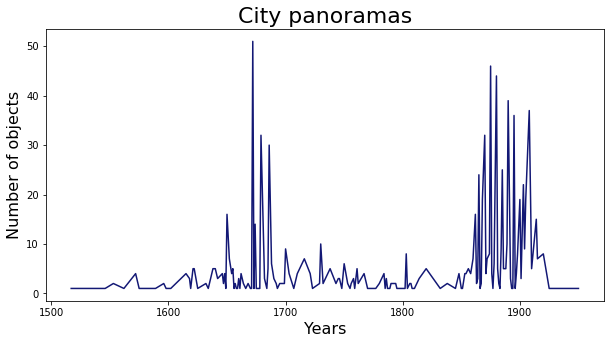

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure( figsize = ( 10,5 ) )

graph = sns.lineplot( x= dates_freq.keys() , y= dates_freq.values() , color = '#131875' )


graph.set_xlabel('Years' , size = 16 )
graph.set_ylabel('Number of objects' , size = 16 )
graph.set_title( 'City panoramas' , size = 22 )


plt.show()

We can see that most of the city panoramas in the Rijksmuseum collection were created either in the last decade of the 17h century or in the second half of the 18th century. This can be an interesting finding for historians. 